# Chapter 4 - Classification

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-whitegrid')

/Users/Young/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


** Load Data **

In [2]:
df = pd.read_excel('Data/Default.xlsx')

**Categories**

Make `default` and `student` columns `Categorical`

In [3]:
df['default'] = df['default'].astype('category')
df['student'] = df['student'].astype('category')

In [4]:
df[['default', 'student']].apply(Series.value_counts)

,default,student
No,9667,7056
Yes,333,2944


## Figure 4.1

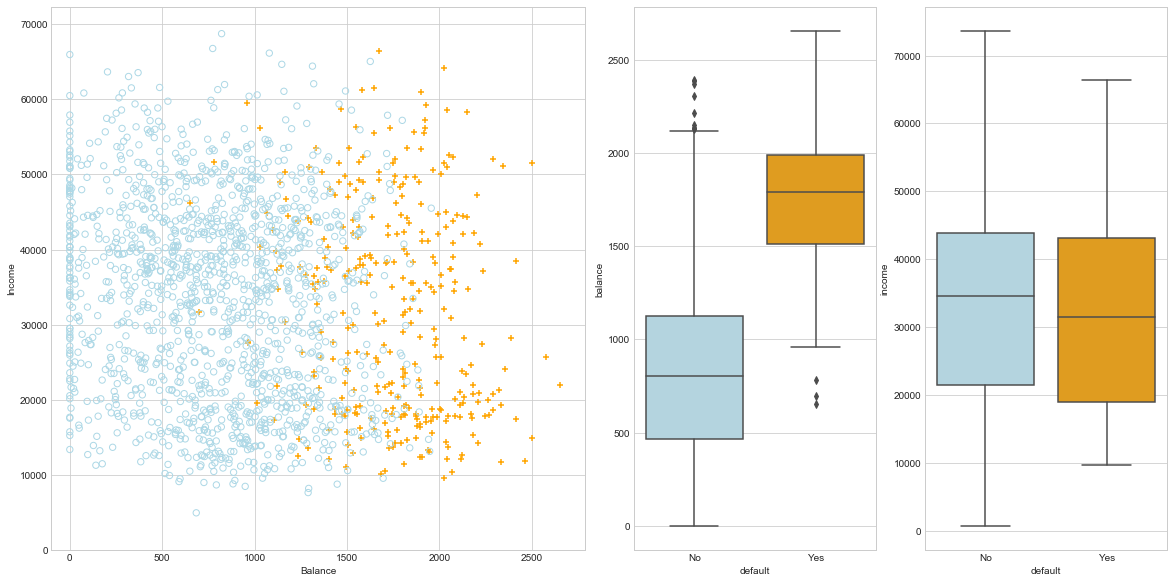

In [5]:
fig = plt.figure(figsize=(20,10))
gs = mpl.gridspec.GridSpec(1,4)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, -2])
ax3 = plt.subplot(gs[0,-1])

# Since there are too many data in No than Yes, Sample some datas
# from No to make scatter plot.
df_no = df[df.default == 'No'].sample(frac=0.15)

ax1.scatter(df[df.default == 'Yes'].balance, df[df.default == 'Yes'].income,
           s=40, c='orange', marker='+', linewidths=1)
ax1.scatter(df_no.balance, df_no.income,
           s=40, edgecolors='lightblue', facecolors='none',
            marker='o', linewidths=1)
ax1.set_ylim(ymin = 0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2,
           palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3,
           palette=c_palette)

## Figure 4.2

In [6]:
X_train = df.balance.values.reshape(-1,1)
y = df.default

In [7]:
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

In [8]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train, y)
prob = clf.predict_proba(X_test)

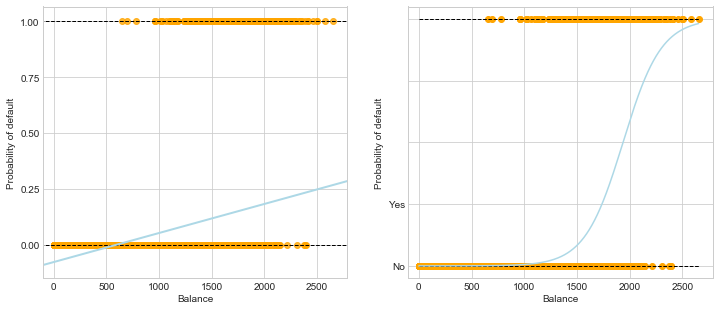

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default.cat.codes, order=1, ci=None,
           scatter_kws={'color':'orange'},
           line_kws={'color':'lightblue', 'lw':2}, ax=ax1)

# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
             xmax=ax.xaxis.get_data_interval()[1], linestyles='--',
             lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
             xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed',
             lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0,0.25,0.5,0.75,1.])
    ax.set_xlim(xmin=-100)
    

In [10]:
clf.predict_proba?

## Table 4.1

In [11]:
y = df.default

### scikit-learn

In [12]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train, y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  ['No' 'Yes']
coefficients:  [[ 0.00549891]]
intercept : [-10.65131936]


### statsmodels
There is an error to use deprecated Scipy function `scipy.stats.chisqprob` in `statsmodels` module. So we need an workaround to avoid this issue.

In [13]:
from scipy import stats
# Workaround
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

Also, `statsmodels` does not support pandas' `category` dtype, so make sure that input data with `cat.codes`

In [14]:
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.cat.codes, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


## Table 4.2

In [15]:
df['student2'] = df['student'].cat.codes

In [16]:
X_train = sm.add_constant(df.student2)
y = df.default

est = smf.Logit(y.cat.codes, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


## Table 4.3 - Multiple Logistic Regression

In [17]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y.cat.codes, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student2,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


## Figure 4.3 - Confounding

In [18]:
# Balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(-1,1)
y = df[df.student == 'Yes'].default.cat.codes

In [19]:
# Balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(-1,1)
y2 = df[df.student == 'No'].default.cat.codes

In [20]:
# Create a range for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

In [21]:
clf = skl_lm.LogisticRegression(solver='lbfgs')
clf2 = skl_lm.LogisticRegression(solver='lbfgs')

In [22]:
clf.fit(X_train, y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [23]:
df.groupby(['student', 'default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


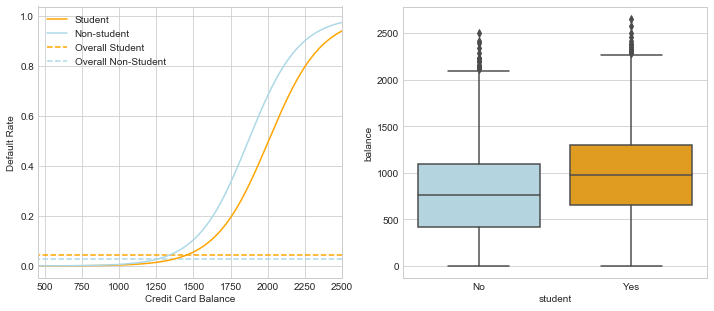

In [24]:
# Create Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/(2817+127), colors='orange', label='Overall Student',
          xmin=ax1.xaxis.get_data_interval()[0],
          xmax=ax1.xaxis.get_data_interval()[1],
          linestyles='dashed')
ax1.hlines(206/(6850+206), colors='lightblue', label='Overall Non-Student',
          xmin=ax1.xaxis.get_data_interval()[0],
          xmax=ax1.xaxis.get_data_interval()[1],
          linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450, 2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,
           palette=c_palette)

## Linear Discriminant Analysis
## Table 4.4

In [25]:
df['student2'] = df['student'].cat.codes
df['default2'] = df['default'].cat.codes
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X,y).predict(X)
y_prob = lda.fit(X,y).predict_proba(X)

df_ = pd.DataFrame({'True': y,
                   'Predicted': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

In [26]:
pd.crosstab(df_['Predicted'],df_['True'], margins=True)

True,No,Yes,All
Predicted,,,
No,9645,254,9899
Yes,22,79,101
All,9667,333,10000


## Table 4.4

In [27]:
decision_prob = 0.2

df_ = pd.DataFrame({'True': y, 'Predicted': y_prob[:,1] > 
                   decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

In [28]:
pd.crosstab(df_['Predicted'],df_['True'], margins=True)

True,No,Yes,All
Predicted,,,
No,9435,140,9575
Yes,232,193,425
All,9667,333,10000


## Figure 4.7, 4.8 - ROC curve for LDA

In [29]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y,y_prob[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

## Figure 4-7
I couldn't find a way to calculate error rate with a proper module, so i calculated by myself. If anyone knows a better way, please let me know.

In [30]:
df = DataFrame({'fpr':fpr, 'tpr':tpr, 'thres':thresholds})
df['FN'] = (1-df['tpr']) * 333
df['FP'] = (df['fpr']*9667)
df['error_rate'] = (df['FP'] + df['FN'])/10000

# default error:
# the fraction of defaulting customers that are incorrectly classfied.
df['default_error'] = (1 - df['tpr'])

# non_default error:
# the fraction of errors among the non-defaulting customers
# == false positive rates.

Text(0,0.5,'Error Rate')

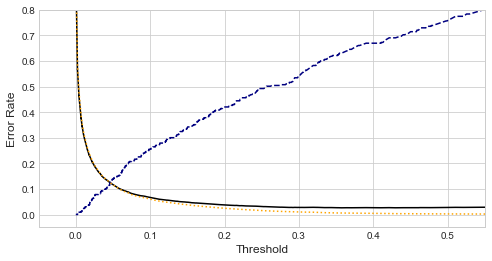

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
# overall error rate
plt.plot(df['thres'],df['error_rate'], c='k')
# default error rate
plt.plot(df['thres'],df['default_error'], c='navy',
        linestyle='--')
# non_default error rate
plt.plot(df['thres'],df['fpr'], c='orange',
        linestyle=':')

ax.set_ylim([-0.05,0.8])
ax.set_xlim([-0.05, 0.55])
ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Error Rate", fontsize=12)

## Figure 4-8

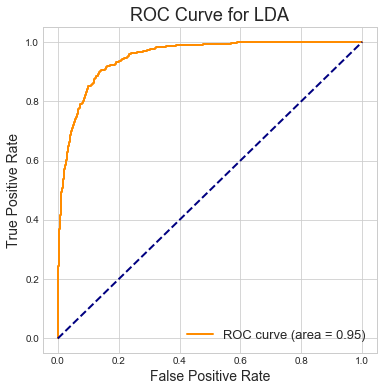

In [32]:
fig, ax =plt.subplots(1,1,figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", 
         label='ROC curve (area = %0.2f)' % roc_auc, lw=2)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='dashed')
ax.set_title("ROC Curve for LDA", fontsize=18)
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.legend(loc="lower right", fontsize=13)

## Figure 4-9
Left : two Gaussian classes have a common correlation of 0.7 between $X_{1}$ and $X_{2}$.

Right : the orange class has a correlation of 0.7 between the variables and the blue class has a correlation of -0.7

In [38]:
from scipy.stats import multivariate_normal
np.random.seed(1)
# Create Frozen objects for future use in Bayes Decision.
rv1_L = multivariate_normal([-1,-1], [[1,0.7],[0.7,1]])
rv2_L = multivariate_normal([1,1], [[1,0.7],[0.7,1]])
rv1_R = multivariate_normal([-1,-1], [[1,0.7],[0.7,1]])
rv2_R = multivariate_normal([1,1], [[1,-0.7],[-0.7,1]])

lnorm1 = rv1_L.rvs(50)
lnorm2 = rv2_L.rvs(50)
rnorm1 = rv1_R.rvs(50)
rnorm2 = rv2_R.rvs(50)

In [39]:
df_lclass0 = DataFrame({'Y': 0, 'X1':lnorm1[:,0], 'X2':lnorm1[:,1]})
df_lclass1 = DataFrame({'Y': 1, 'X1':lnorm2[:,0], 'X2':lnorm2[:,1]})
df_L = df_lclass0.append(df_lclass1)

df_rclass0 = DataFrame({'Y': 0, 'X1':rnorm1[:,0], 'X2':rnorm1[:,1]})
df_rclass1 = DataFrame({'Y': 1, 'X1':rnorm2[:,0], 'X2':rnorm2[:,1]})
df_R = df_rclass0.append(df_rclass1)

These are what i will use for Figure 4-9
- LinearDiscriminantAnalysis
- QuadraticDiscriminantAnalysis
- Bayes Decision Boundary

** LDA and QDA **

In [40]:
# Left
lda_L = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
qda_L = QuadraticDiscriminantAnalysis(store_covariance=True)
X = df_L[['X1','X2']]
y = df_L['Y']
lda_L.fit(X,y)
qda_L.fit(X,y)

# Right
lda_R = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
qda_R = QuadraticDiscriminantAnalysis(store_covariance=True)
X = df_R[['X1','X2']]
y = df_R['Y']
lda_R.fit(X,y)
qda_R.fit(X,y)

lda = [lda_L, lda_R]
qda = [qda_L, qda_R]

**Bayes Decision Boundary**

In [41]:
def bayes_get_proba(data, rv1, rv2):
    return rv2.pdf([data[0],data[1]]) / (rv1.pdf([data[0],data[1]]) + rv2.pdf([data[0],data[1]]))
rv = [[rv1_L,rv2_L],
      [rv1_R,rv2_R]]

**Plot**

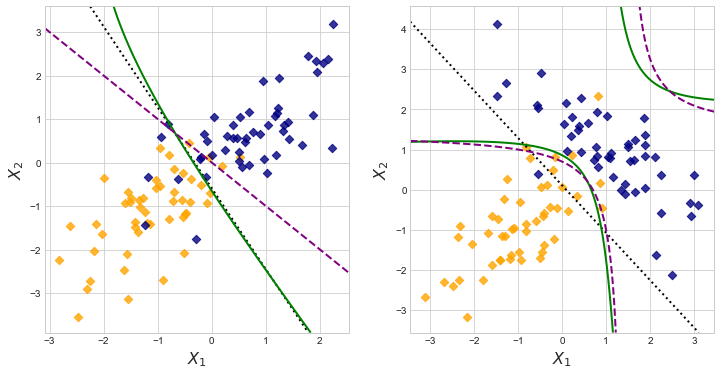

In [42]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

# Left Scatter Plot
sns.regplot(df_lclass0['X1'],df_lclass0['X2'],ax=axes[0], 
            fit_reg=False, color='orange', marker='D')
sns.regplot(df_lclass1['X1'],df_lclass1['X2'],ax=axes[0], 
            fit_reg=False, color='navy', marker='D')

# Right Scatter Plot
sns.regplot(df_rclass0['X1'],df_rclass0['X2'],ax=axes[1], 
            fit_reg=False, color='orange', marker='D')
sns.regplot(df_rclass1['X1'],df_rclass1['X2'],ax=axes[1], 
            fit_reg=False, color='navy', marker='D')

nx, ny = 200, 200

for i in range(2):
    x_min, x_max = axes[i].get_xlim()
    y_min, y_max = axes[i].get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    
    # Decision Boundaries
    # LDA
    Z = lda[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='k',
                   linestyles='dotted')
    # QDA
    Z = qda[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='green',
                   linestyles='solid')
    
    # Bayes Decision Boundary
    Z = (DataFrame({'x':xx.ravel(),'y':yy.ravel()})
        .apply(bayes_get_proba, args=(rv[i][0],rv[i][1]), axis=1)
        .values.reshape(xx.shape))
    
    axes[i].contour(xx, yy, Z, [0.5], linewidths=2., colors='purple',
                   linestyles='dashed')
    
for i in range(2):
    axes[i].set_xlabel('$X_{1}$', fontsize=16)
    axes[i].set_ylabel('$X_{2}$', fontsize=16)

## Issue with Figure 4-9
I think there is a problem with Bayes Decision Boundary in left plot. So be careful to write this code. I don't know why this happened, but i will come back later to this issue.